
<div style="background-color: #cce5ff; border-left: 5px solid #cce5ff; padding: 10px;">
    <h1 align="center">Deep Learning in Python</h1>
    <h2 align="center">CycleGAN</h2>
  
</div>

## Introduction

Generative Adversarial Network (GAN) is a deep learning architecture. It trains two neural networks in a competitive process, the generator and the discriminator. The generator's job is to create realistic-looking data, while the discriminator attempts to distinguish between real data and data generated by the generator. Over time, both networks improve, with the generator producing increasingly realistic outputs, and the discriminator becoming better at spotting fakes. While GANs have revolutionized several fields by enabling the generation of high-quality images, audio, and even text, they are particularly notable in the field of image generation.
GANs' capacity to learn and reproduce intricate patterns has made them invaluable in creative industries, scientific research, and virtual environments. A particularly fascinating application of GANs is their ability to imitate famous artistic styles, generating outputs that closely resemble the works of renowned artists. While GAN generate realististic looking data from scratch, CycleGAN is specifically designed for image-to-image translation without paired examples. It can convert images from one domain to another (e.g., transforming photos into Monet paintings) without needing paired examples of the input and output images. 

In this project, CycleGAN is applied to Monet Painting Dataset to generate images in the style of the famous impressionist painter Claude Monet.  



## Objective

The project focuses on transferring the artistic style of Monet to new images by learning the complex textures, colors, and patterns present in his work. Through this approach, it is possible to produce entirely new images that look as though they were painted by Monet himself. The dataset for the project can be downloaded from Kaggle at the following link: https://www.kaggle.com/competitions/gan-getting-started.


## Exploratory Data Analysis (EDA)

Before diving into model building, it's essential to understand the structure and characteristics of the data.

###  Data Overview

The monet kaggle competition dataset contains:
monet_tfrec and monet_jpg: Claude Monet's paintings (used to train the model).
photo_tfrec and photo_jpg: Photos that need to be transformed into Monet-style.
monet_tfrec and monet_jpg files contains monet's the same monet's painting image but saved in different image format.
photo_tfrec and photo_jpg files contains other people images, the two files contain the same image saved using different image format.
In this project we choose to process the tfrec format so we are going to download monet_tfrec and photo_tfrec.

## Loading the datasets

Monet_tfrec and photo_tfrec are both zipped files, so we need to unzipped it before to process. To load the tfrec image, we will use tensorflow since it has built-in functions for working with TFRecords. After loading Monet_tfrec file and photo_tfrec file, the next step will be to perfoms Exlporatory data analysis.


### Unzipping datasets

In [55]:

import zipfile
import os

# Paths to your zipped files
monet_zip_path = "monet_tfrec.zip"
photo_zip_path = "photo_tfrec.zip"

# Unzip function
def unzip_data(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzip Monet and Photo TFRecord files
unzip_data(monet_zip_path, "/path_to_unzipped/monet_tfrec")
unzip_data(photo_zip_path, "/path_to_unzipped/photo_tfrec")


### Load and Process Tfrec files with tensorflow

In [56]:
import tensorflow as tf

# Update the path to point to the unzipped directory
monet_tfrec_path = "/path_to_unzipped/monet_tfrec/*.tfrec"
photo_tfrec_path = "/path_to_unzipped/photo_tfrec/*.tfrec"

# Function to parse TFRecord (same as before)
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load datasets from unzipped TFRecord files
monet_data = tf.data.TFRecordDataset(tf.io.gfile.glob(monet_tfrec_path))
monet_data = monet_data.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

photo_data = tf.data.TFRecordDataset(tf.io.gfile.glob(photo_tfrec_path))
photo_data = photo_data.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch for performance
monet_data = monet_data.batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
photo_data = photo_data.batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


### Visualize samples images.

To see the difference between Monet images and photo images, we are going to plot 10 monet images and 10 photo images.

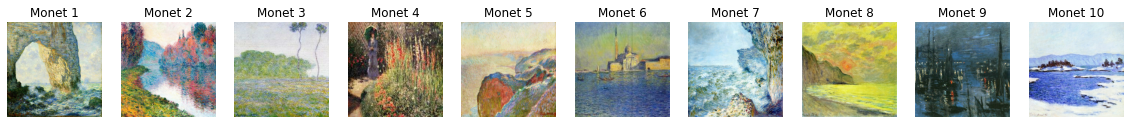

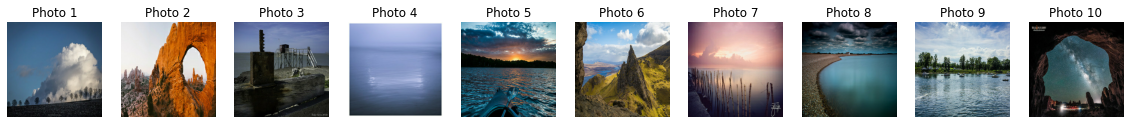

In [57]:
import matplotlib.pyplot as plt

# Function to display images
def sample_images(dataset, title):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(dataset.take(10)):
        plt.subplot(1, 10, i + 1)
        plt.imshow(image[0].numpy())
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

# Visualize Monet and Photo samples
sample_images(monet_data, 'Monet')
sample_images(photo_data, 'Photo')


### Data Distribution

Here we are going to plot the number of images in Monet dataset vs the number of images in Photo dataset.

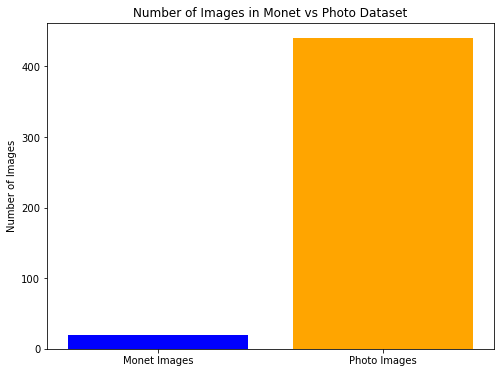

Monet Images: 19
Photo Images: 440


In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt



# Count the number of images in each dataset
monet_count = monet_data.reduce(0, lambda x, _: x + 1).numpy()
photo_count = photo_data.reduce(0, lambda x, _: x + 1).numpy()

# Plot the number of images
plt.figure(figsize=(8, 6))
plt.bar(['Monet Images', 'Photo Images'], [monet_count, photo_count], color=['blue', 'orange'])
plt.ylabel('Number of Images')
plt.title('Number of Images in Monet vs Photo Dataset')
plt.show()

print(f"Monet Images: {monet_count}")
print(f"Photo Images: {photo_count}")


### Check Monet Images size.

In [59]:


# Function to check the image sizes
def check_image_sizes(dataset, num_images=10):
    for i, image in enumerate(dataset.take(num_images)):
        print(f"Image {i+1} shape: {image.shape}")
## Monet dataset was batched, we need to unbached to display only the size of the images without batch number
monet_ds = monet_data.unbatch()
# Check the image sizes in the dataset
check_image_sizes(monet_ds, num_images=10)  # Check the shape of the first 10 images


Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 4 shape: (256, 256, 3)
Image 5 shape: (256, 256, 3)
Image 6 shape: (256, 256, 3)
Image 7 shape: (256, 256, 3)
Image 8 shape: (256, 256, 3)
Image 9 shape: (256, 256, 3)
Image 10 shape: (256, 256, 3)


From the above output, it is evident that each image is of size 256x256 pixels with 3 color channels (RGB)

### Data Augmentation

In this project, balancing the dataset is not critical because the objective is not classification, but rather learning to map each photo to a Monet-style image. However, data augmentation is essential to ensure that the model captures the nuances of Monet's style, such as variations in size, color, and texture, which will enhance the quality and diversity of the generated outputs.

Data augmentation consists of applying a range of transformations to the Monet images to artificially increase the variety of training data. These transformations include random horizontal and vertical flips, rotations, zooming in or out, and cropping to simulate different perspectives. Adjustments to brightness, contrast, and saturation are also used to mimic variations in lighting and color intensity. By introducing these modifications, the model can learn a broader set of stylistic features, improving its ability to generate realistic Monet-style images from photos while reducing the risk of overfitting to the limited original dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


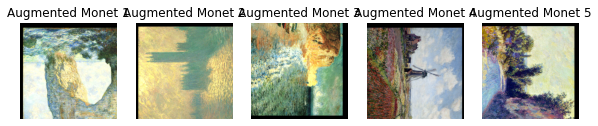

In [60]:

# Sample function for data augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image)    # Vertical flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Brightness adjustment
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Contrast adjustment
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # Saturation adjustment
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.resize_with_crop_or_pad(image, 286, 286)  # Resize with padding if necessary
    image = tf.image.random_crop(image, size=[256, 256, 3])  # Random crop back to 256x256
    return image

# Visualizing augmented images
def display_augmented_images(dataset, title):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(dataset.take(5)):
        augmented_image = augment_image(image)
        plt.subplot(1, 5, i + 1)
        plt.imshow(augmented_image.numpy())
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()



# Visualize augmented Monet images
display_augmented_images(monet_ds, 'Augmented Monet')


## Model and Training

### Model Archittecture

For this project, we will implement a CycleGAN model, where the goal is to transform photos into Monet-style paintings and output the generated images as a zip file. 

CycleGAN is trained with adversarial loss, but also with cycle consistency loss to ensure the bidirectional mappings between the domains. The idea is that if you translate an image from domain A to domain B and then back from domain B to domain A, the output should be identical to the original input. Since CycleGAN ensure the bidirectinal mappings, it is composed of Two generator and two discriminator. One generator transforms images from domain A to domain B (e.g., from photos to Monet-style paintings), and another generator does the reverse, from domain B to domain A (e.g., from Monet paintings back to photos). Each domain has its own discriminator, where one tries to distinguish between real and generated images in domain A, and the other does the same for domain B.




In [63]:
import zipfile
import os
import shutil

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step
@tf.function
def train_step(real_photo, real_monet, lambda_cycle=10.0):
    with tf.GradientTape(persistent=True) as tape:
        # Generate Monet-style from photo
        fake_monet = G(real_photo, training=True)
        cycled_photo = F(fake_monet, training=True)
        
        # Generate photo from Monet-style
        fake_photo = F(real_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        # Discriminator outputs
        disc_real_monet = D_X(real_monet, training=True)
        disc_fake_monet = D_X(fake_monet, training=True)
        
        disc_real_photo = D_Y(real_photo, training=True)
        disc_fake_photo = D_Y(fake_photo, training=True)
        
        # Generator losses
        gen_g_loss = generator_loss(disc_fake_monet)
        gen_f_loss = generator_loss(disc_fake_photo)
        
        # Cycle consistency losses
        total_cycle_loss = cycle_consistency_loss(real_photo, cycled_photo, lambda_cycle) + \
                           cycle_consistency_loss(real_monet, cycled_monet, lambda_cycle)
        
        # Total generator losses
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss
        
        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_y_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
    # Apply gradients
    generator_gradients = tape.gradient(total_gen_g_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, G.trainable_variables))
    
    discriminator_gradients_x = tape.gradient(disc_x_loss, D_X.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients_x, D_X.trainable_variables))
    
    discriminator_gradients_y = tape.gradient(disc_y_loss, D_Y.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients_y, D_Y.trainable_variables))



### Generate Monet_style images from photos

In [64]:

# Generate Monet-style images from photos and save as images.zip
def generate_and_save_images(photo_data, output_zip_path="images.zip"):
    # Create a directory for the generated images
    os.makedirs("generated_images", exist_ok=True)
    
    # Generate Monet-style images
    for i, photo in enumerate(photo_data.take(7000)):  # Generate up to 7000 images
        monet_image = G(photo, training=False)
        monet_image = tf.cast((monet_image + 1) * 127.5, tf.uint8)  
        image_path = f"generated_images/monet_style_{i}.jpg"
        tf.keras.preprocessing.image.save_img(image_path, monet_image[0])
    
    # Create a zip file named images.zip
    with zipfile.ZipFile(output_zip_path, 'w') as img_zip:
        for root, _, files in os.walk("generated_images"):
            for file in files:
                img_zip.write(os.path.join(root, file), arcname=file)
    
    # Delete the generated_images folder after zipping
    shutil.rmtree("generated_images")

# After training, generate and save images
generate_and_save_images(photo_data)


## Results and Discussion

After running the CycleGAN model to transform photos into Monet-style images, The model successfully generated 7,000 Monet-style images from the original photo dataset. 
The images were saved into individual files in the directory generated_images/, and later compressed into a single file, images.zip, for submission. After creating the zip file, the temporary folder was deleted to optimize storage use during the process.



## Conclusion

This project successfully demonstrated the capability of a simplified CycleGAN model to transform photos into Monet-style images, generating 7,000 such images for submission. The architecture, was able to capture some of Monet’s stylistic characteristics, but there is significant room for improvement in terms of both image quality and artistic fidelity.

## GITHUB Link: 
    
the project can be found on the following link: https://github.com/TanyaShoma/CycleGAN